# Used-Cars Price Prediction

In [9]:
# Imports
 
# File operations
import pandas as pd
 
# For calculations and visualisation
import numpy as np
#to compute the skewness of the dataset
from scipy.stats import skew
import matplotlib.pyplot as plt
 
# To tabulate the data
from tabulate import tabulate
 
# For kmeans clustering
from sklearn.cluster import KMeans
 
# Supporting K means and dimensionality reduction
from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA
 
#to encode categorical values
from sklearn.preprocessing import OneHotEncoder
 
# splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split
#for regression tasks to predict continuous numeric values
from sklearn.tree import DecisionTreeRegressor
 
#for hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV
#metrics for assessing the performance of regression models
from sklearn.metrics import mean_squared_error, r2_score
#a number of decision tree regressors on various sub-samples of the dataset
from sklearn.ensemble import RandomForestRegressor
#export the decision tree visualization to a Graphviz format file
from sklearn.tree import export_graphviz
#to visualize decision trees
import graphviz
#for image processing using keras
import tensorflow as tf
 
# Sequential api -> more simple, single input, single output
# Conv2D -> Convolutional Neural Network Layer
# MaxPooling2D -> Returns the max value of a region by condensing it down
# Flatten -> Reduces the channels or kernals that Conv2D uses so that it can be taken as input by the Dense Layer
# Dense -> Used for regularisation
 
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
 
from sklearn.metrics import confusion_matrix
import seaborn as sns

## 1. Sampling

Original dataset size is around 9.29GB.
Sampling is done once and all subsequent tasks use the sampled data.
Running sampling again is not advised since it is time-consuming.

In [ ]:
#Reading the original CSV file

cars = pd.read_csv('../data/original_dataset/used_cars_data-2.csv')

# Salvage field is a value given by insurance companies.
# If its True, it means the cost of repairing exceeds their value
# So we remove it
cars = cars.drop(cars[(cars['salvage'] == True)].index)

[Link to Original Dataset](https://www.kaggle.com/datasets/ananaymital/us-used-cars-dataset)

In [ ]:
cars = cars[~(cars['bed_height'].notna() | cars['bed_length'].notna() | cars['bed'].notna() | cars['cabin'].notna())]
cars = cars.dropna(subset = ['daysonmarket', 'engine_displacement', 'frame_damaged', 'highway_fuel_economy', 'listed_date', 'mileage', 'torque', 'city', 'engine_type','fuel_type','horsepower','model_name','transmission','wheel_system','city_fuel_economy','exterior_color','has_accidents','interior_color','is_new','make_name','owner_count','transmission_display','year','isCab','maximum_seating','price','theft_title','trim_name','body_type','salvage'])
cars = cars.drop(['exterior_color','interior_color','transmission','salvage','listed_date','vin','cabin','fuel_tank_volume','is_certified','main_picture_url','savings_amount','vehicle_damage_category', 'wheelbase', 'back_legroom', 'dealer_zip', 'franchise_dealer','is_cpo','listing_color','major_options','seller_rating','width','bed','description','franchise_make','listing_id','sp_id','wheel_system_display','bed_height','combine_fuel_economy','engine_cylinders','fleet','front_legroom','height','is_oemcpo','longitude','power','sp_name','trimId','bed_length','latitude','length'], axis=1)
cars = cars.drop(cars[(cars['body_type'] == 'Wagon') | (cars['body_type'] == 'Minivan') | (cars['body_type'] == 'Van' )].index)                                                                                             
cars.head()

In [ ]:
# Not considering cars before the year 2000
cars = cars.drop(cars[cars['year'] < 2000].index)
cars['torque_lbft'] = cars['torque'].str.extract(r'(\d+) lb-ft').astype(int)
cars.drop('torque', axis=1, inplace=True)
cars.rename(columns={'torque_lbft': 'torque'}, inplace=True)

[Features removed](https://github.com/dmml-heriot-watt/group-coursework-sa3n/blob/main/documentation/DataCleaning.docx)

In [ ]:
#only selecting 10% of the data to reduce the dataset size
#random_state ensures reproduceability acroos runs
cars = cars.sample(frac=0.1, random_state=42)
#code to remove any inline duplicate rows
cars.drop_duplicates(inplace=True)

In [ ]:
#sampled data is then exported as a csv file
cars.to_csv('../data/used_cars_data.csv', index=False)

[Link to Sampled Dataset](https://github.com/dmml-heriot-watt/group-coursework-sa3n/blob/main/data/used_cars_data.csv)

## 2. Summary and Visualisation

**Begin execution from here**

### Summary Stats

In [10]:
df = pd.read_csv('../data/used_cars_data.csv')

price_summary = df['price'].describe()

# Print the summary statistics
print("Price Summary Statistics")
# Use tabulate to print the summary as a nice table
print(tabulate(price_summary.reset_index(), headers=['Statistic', 'Value'], tablefmt='pretty', showindex=False))

Price Summary Statistics
+-----------+--------------------+
| Statistic |       Value        |
+-----------+--------------------+
|   count   |      92539.0       |
|   mean    | 21378.36076681183  |
|    std    | 16621.812455541258 |
|    min    |       495.0        |
|    25%    |      13500.0       |
|    50%    |      18631.0       |
|    75%    |      26000.0       |
|    max    |     1499999.0      |
+-----------+--------------------+


Mean >> Median (50% Quartile).
This is because the data is skewed and there are small number of high values pulling the mean

### Skewness in Data

In [11]:
# Determine skewness

price_data=df['price']
skewness = skew(price_data)
print("Skewness:", skewness)

Skewness: 21.486401394577975


In [12]:
print(min(price_data), max(price_data))

495.0 1499999.0


### Box Plot

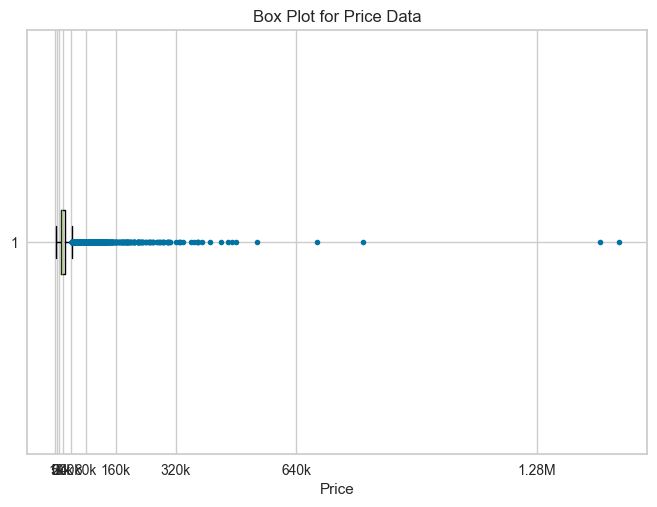

In [13]:
# Create a box plot for the price data
plt.boxplot(price_data, vert=False, sym='b.')
plt.xlabel('Price')

plt.title('Box Plot for Price Data')

x_ticks = [0, 5000, 10000, 20000, 40000, 80000, 160000, 320000, 640000, 1280000]
x_tick_labels = ['0', '5k', '10k', '20k', '40k', '80k', '160k', '320k', '640k', '1.28M']
plt.xticks(x_ticks, x_tick_labels)

# Output
plt.show()

The data is clearly skewed. We try to apply log transformation on prices to mitigate this.

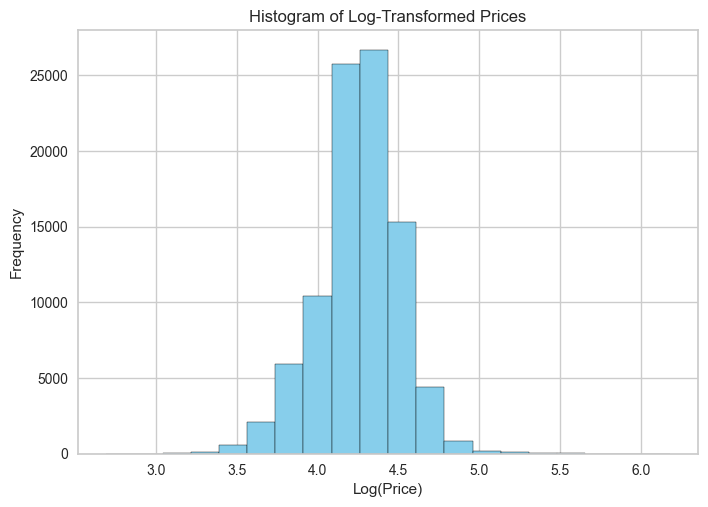

In [14]:
# Log-transform the prices
log_price_data = np.log10(price_data)  # Using np.log1p to handle potential zero values

# Create a histogram of log-transformed prices
plt.hist(log_price_data, bins=20, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Log(Price)')
plt.ylabel('Frequency')
plt.title('Histogram of Log-Transformed Prices')

# Show the plot
plt.show()

- The data becomes slightly normal with log transformation. 
- We can go with log transformed data and accordingly perform calculations to get the right predicted value of price when a prediction is made using our code.
- Or we could simply use this for our understanding that the data is skewed and realistic.

### Outliers

In [15]:
# Calculate the IQR for the price column
Q1 = price_data.quantile(0.25)
Q3 = price_data.quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

If we cap the data based on the upper and lower bounds, we should be able to see less skewness in our data as shown in the box plaot below.

In [16]:
# Cap the outliers by setting them to the lower or upper bound
price_data = price_data.clip(lower_bound, upper_bound)

print(min(price_data),max(price_data))

495.0 44750.0


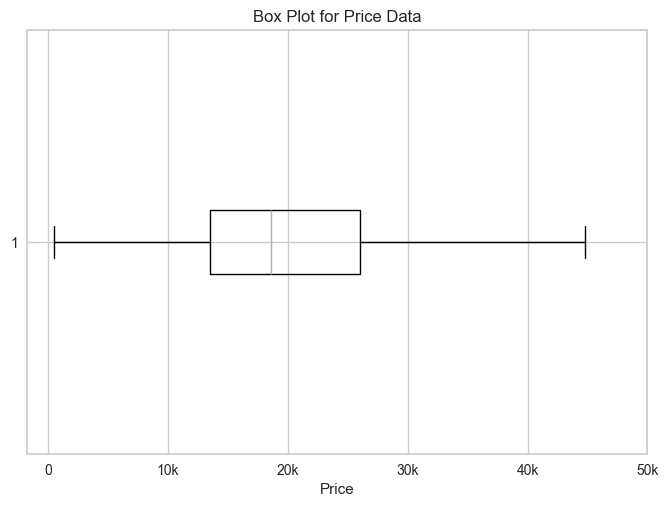

In [17]:
plt.boxplot(price_data, vert=False, sym='b.')
plt.xlabel('Price')

# Add a title
plt.title('Box Plot for Price Data')

# Set custom x-axis ticks and labels
x_ticks = [0, 10000, 20000, 30000, 40000, 50000]
x_tick_labels = ['0', '10k', '20k', '30k', '40k', '50k']
plt.xticks(x_ticks, x_tick_labels)

# Show the box plot
plt.show()

### Conclusions

- Clipping outliers based on the upper bound found could affect the predictive accuracy of the model in certain scenarios. For example, for high-end cars.
- The model may also under-predict the prices for cars that should actually be more than the upper bound.

Therefore, we choose to keep our data realistic despite the skewness

## 3. Identify Some Price Ranges

### Categorizing Price Variable

The idea here is to categorize price to be able to classify it into 3 groups:
1. Low range
2. Mid range
3. High range

We could have used our knowledge of the market prices for used-cars to arrive at the price range for each category. Instead we use k-means clustering to group the price data points.

**This is used in Task 1: Clustering in the next section**, where we perform clustering of the independent variables and try to determine the price bracket to which each cluster falls.


In [18]:
# Define the number of clusters K. Choosing 3 because we need 3 categories
K = 3

# Use the sampled data
data = pd.read_csv('../data/used_cars_data.csv')

# Get the price column
# Reshape required since clustering applied to just 1 column
price_values = data['price'].values.reshape(-1, 1)

# Create K-Means model
kmeans = KMeans(n_clusters=K, random_state=42, n_init=20)

# Fit the model to the price data
kmeans.fit(price_values)

# Fetch the cluster labels for each data point
cluster_labels = kmeans.labels_

# Add new column price_category that stores cluster labels
data['price_category'] = cluster_labels


cluster:  0 70141
cluster:  1 22276
cluster:  2 122


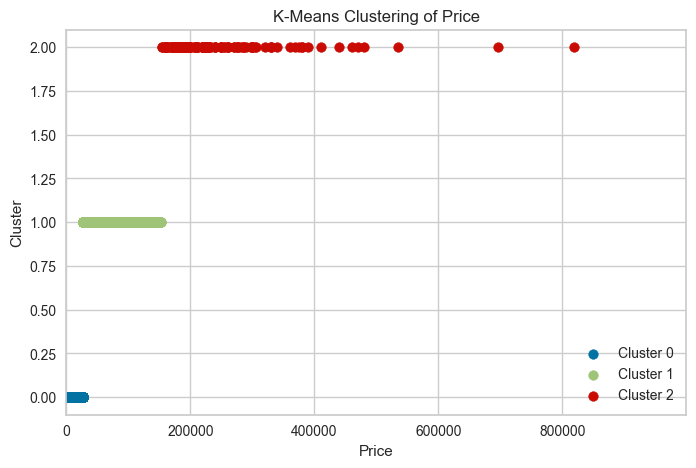

In [19]:
plt.figure(figsize=(8, 5))
for cluster in range(K):
    # Getting data points which belong to a cluster
    cluster_data = data[data['price_category'] == cluster]
    print("cluster: ", cluster, len(cluster_data))
    plt.scatter(cluster_data['price'], [cluster] * len(cluster_data), label=f'Cluster {cluster}')

plt.xlim(0, 999999)

plt.xlabel('Price')
plt.ylabel('Cluster')
plt.title('K-Means Clustering of Price')
plt.legend()
plt.show()

In [20]:
price_and_category = data[['price', 'price_category']]
print(price_and_category)
price_and_category.head()

         price  price_category
0      20988.0               0
1      37395.0               1
2      11000.0               0
3       8608.0               0
4      18998.0               0
...        ...             ...
92534  20323.0               0
92535  13900.0               0
92536  25941.0               0
92537   2750.0               0
92538  11995.0               0

[92539 rows x 2 columns]


price  price_category
0  20988.0               0
1  37395.0               1
2  11000.0               0
3   8608.0               0
4  18998.0               0

In [21]:
cluster_info = []

for cluster in range(K):
    cluster_data = price_values[cluster_labels == cluster]
    #print(cluster_data)
    cluster_mean = np.mean(cluster_data)
    cluster_min = np.min(cluster_data)
    cluster_max = np.max(cluster_data)
    cluster_len = len(cluster_data)
    cluster_info.append({
        'Cluster': cluster,
        'Mean Price': cluster_mean,
        'Min Price': cluster_min,
        'Max Price': cluster_max,
        'Cluster Size' : cluster_len
    })

# Sort the cluster info by mean price
cluster_info.sort(key=lambda x: x['Mean Price'])

# Assign categories of low, medium, and high based on the cluster information
for i, cluster in enumerate(cluster_info):
    if i == 0:
        category = 'Low Price'
    elif i == K - 1:
        category = 'High Price'
    else:
        a = str(i)
        category = 'Medium Price'
    cluster['Category'] = category


In [22]:
print(cluster_info)

[{'Cluster': 0, 'Mean Price': 15866.12480603356, 'Min Price': 495.0, 'Max Price': 26614.0, 'Cluster Size': 70141, 'Category': 'Low Price'}, {'Cluster': 1, 'Mean Price': 37373.71606123182, 'Min Price': 26621.0, 'Max Price': 152995.0, 'Cluster Size': 22276, 'Category': 'Medium Price'}, {'Cluster': 2, 'Mean Price': 269912.8524590164, 'Min Price': 154888.0, 'Max Price': 1499999.0, 'Cluster Size': 122, 'Category': 'High Price'}]


In [23]:
data.to_csv('../data/pre_encoded_price_categorized.csv', index=False)

### Splitting and Encoding the Data

- Split the dataset to training and test sets [(here)](../notebooks/train_test_split.ipynb)
- Stratified shuffle split splits the data more uniformly based on price categories

- Used target encoding to encode categorical variables before applying K means clustering [(here)](../notebooks/target_encoding.ipynb)

- Also tried one-hot encoding [(here)](../notebooks/one_hot_encoding.ipynb)

# Task 1 - Clustering

In [24]:
data = pd.read_csv('../data/training_set_target_encoded.csv')

## Using Elbow Method
To calculate an approximately good value for K

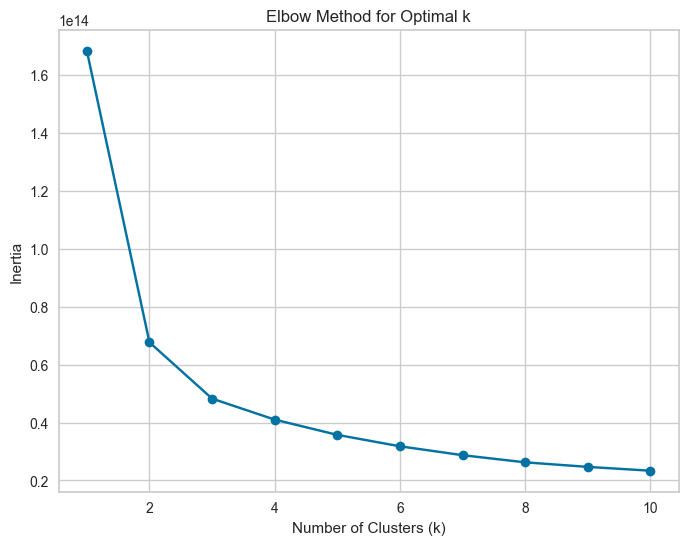

In [25]:
# Plot inertia against different possible number of clusters

# Remove price to get only the independent variables
# Also removing price_category as it is not part of original dataset and is not required for clustering

X = data.drop(['price', 'price_category'], axis=1)

# Initialize list to store the inertia values
inertia = []

# Get inertia for each k

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot inertia against k
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

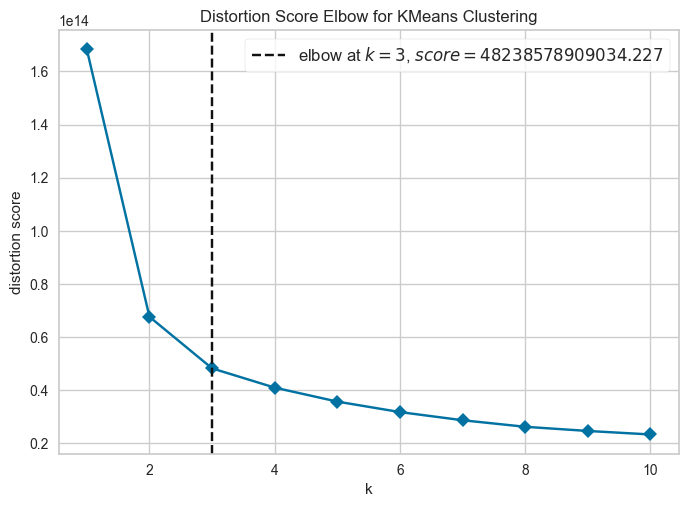

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [26]:
# yellowbrick helps us fetch the appropriate value for k

model = KMeans(random_state=42, n_init=10)
visualizer = KElbowVisualizer(model, k=(1,11), timings = False)
visualizer.fit(X)
visualizer.show()

## Clustering

In [27]:
no_of_clusters = 3
kmeans = KMeans(n_clusters=no_of_clusters, random_state=42, n_init=10)
kmeans.fit(X)
cluster_labels = kmeans.labels_
data['cluster'] = cluster_labels
df = data[['price', 'price_category', 'cluster']]
df.head()

price  price_category  cluster
0  19803.0               1        0
1  46806.0               0        0
2  16500.0               1        2
3  37700.0               0        0
4  12684.0               1        2

In [28]:
# Calculate average price for each cluster
cluster_avg_price = data.groupby('cluster')['price'].mean()

# Find the predominant price_category for each cluster
cluster_predominant_category = data.groupby('cluster')['price_category'].agg(lambda x: x.mode().iloc[0])

# Create a new DataFrame to store the results
cluster_results = pd.DataFrame({'Cluster': cluster_avg_price.index,
                                 'Average Price': cluster_avg_price.values,
                                 'Predominant Price Category': cluster_predominant_category.values})

# Display the cluster results
print(cluster_results)

   Cluster  Average Price  Predominant Price Category
0        0   26231.758834                           1
1        1    8679.890394                           1
2        2   15143.116867                           1


In [29]:
data.to_csv('../data/clustered.csv')

## Visualising the Clusters

We use Principal Component Analysis for visualising because to actually view the results of clustering, we need our data to be 2 dimensional. For this we use PCA dimensionality reduction technique which sort of expresses the 2 principal components, which we will get from using this technique, as a linear combination of all the original features that capture maximum variance in the data (so as to capture maximum variability or more patterns in the data).

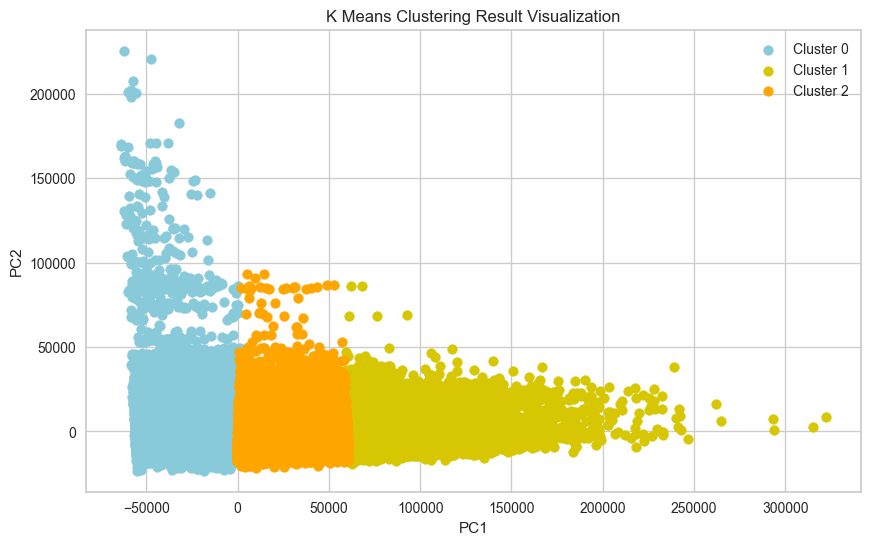

In [30]:
# Reduce the dimensionality of the features to 2 using PCA
# Using 2 because we want to visualise the data
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

# Adding cluster labels to the reduced feature data
reduced_features = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
reduced_features['Cluster'] = cluster_labels

# Plot the clusters
plt.figure(figsize=(10, 6))
#colors = ['r', 'g', 'b', 'c', 'y', 'orange', 'pink', 'violet', 'brown', 'indigo']
colors = ['c', 'y', 'orange']
for cluster_id, color in enumerate(colors):
    #print(cluster_id)
    cluster_points = reduced_features[reduced_features['Cluster'] == cluster_id]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], c=color, label=f'Cluster {cluster_id}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('K Means Clustering Result Visualization')
plt.legend()
plt.show()

In [31]:
reduced_features.head()
print(len(reduced_features), len(cluster_labels))


74036 74036


Next, we are applying dimensionality reduction with PCA and colouring based on the price categories to be able to compare clusters and their price ranges.

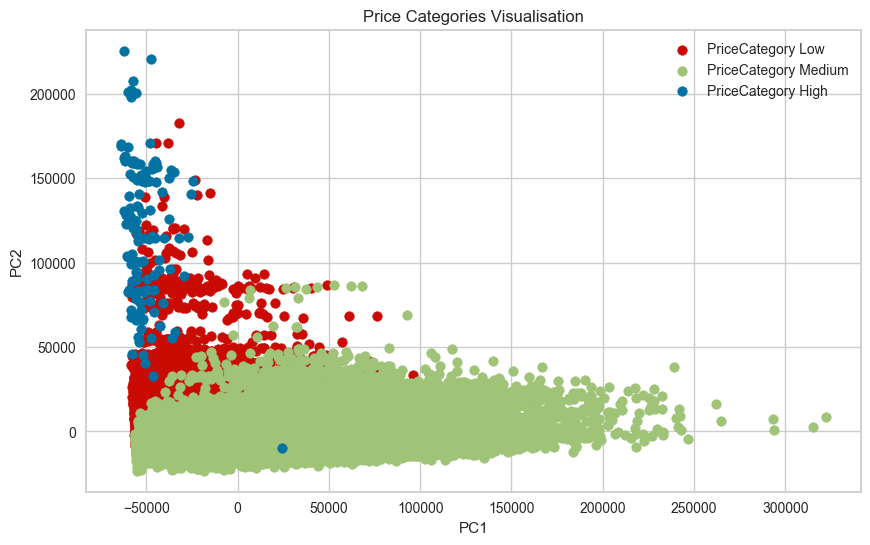

In [32]:
# Reduce the dimensionality of the features to 2 using PCA
# Using 2 because we want to visualise the data
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(X)

# Adding cluster labels to the reduced feature data
reduced_features = pd.DataFrame(reduced_features, columns=['PC1', 'PC2'])
reduced_features['PriceCategory'] = data['price_category']

# Plot the clusters
plt.figure(figsize=(10, 6))
colors = ['r', 'g', 'b']
price_categ_names = ['Low', 'Medium', 'High']
for id, color in enumerate(colors):
    cluster_points = reduced_features[reduced_features['PriceCategory'] == id]
    plt.scatter(cluster_points['PC1'], cluster_points['PC2'], c=color, label=f'PriceCategory {price_categ_names[id]}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Price Categories Visualisation')
plt.legend()
plt.show()

## Conclusions

1. Our dataset for used-cars price prediction contains labelled data. i.e., the dataset contains price (dependent variable) values. Therefore, the ideal way would be supervised learning.
2. In order to perform clustering, we encoded all variables and performed k-means clustering on all columns except price and price_category.
3. On analysing the clusters, we see that the average price for most of the clusters falls into the low or medium price categories.
4. This indicates clustering might not be a useful technique for our specific task.
5. No cluster stands out from the visualisation as well.

### Additional Features Explored

1. [Correlation Matrix](https://github.com/dmml-heriot-watt/group-coursework-sa3n/blob/main/notebooks/correlation_matrix.ipynb)
2. [DBScan Clustering](https://github.com/dmml-heriot-watt/group-coursework-sa3n/blob/main/notebooks/dbscan_clustering.ipynb)

## Decision Tree

### Importing the dataset

In [2]:
cars_df = pd.read_csv('../data/used_cars_data.csv')

In [3]:
cars_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92539 entries, 0 to 92538
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   body_type             92539 non-null  object 
 1   city                  92539 non-null  object 
 2   city_fuel_economy     92539 non-null  float64
 3   daysonmarket          92539 non-null  int64  
 4   engine_displacement   92539 non-null  float64
 5   engine_type           92539 non-null  object 
 6   frame_damaged         92539 non-null  bool   
 7   fuel_type             92539 non-null  object 
 8   has_accidents         92539 non-null  bool   
 9   highway_fuel_economy  92539 non-null  float64
 10  horsepower            92539 non-null  float64
 11  isCab                 92539 non-null  bool   
 12  is_new                92539 non-null  bool   
 13  make_name             92539 non-null  object 
 14  maximum_seating       92539 non-null  object 
 15  mileage            

### Encoding the categorical variables - One-Hot Encoding

Applying one-hot encoding for the following reasons: 
1. to preserve the independence among categories,
2. compatibility with various algorithms that require numerical inputs
3. prevents misinterpretation of ordinal data 
4. offers flexibility in handling variable cardinality
5. avoids weighted averaging issues
6. remains robust to outliers
7. encourages non-linearity in models, making it a versatile choice for encoding categorical information in diverse machine learning applications

In [4]:
categorical_columns = cars_df.select_dtypes(include=['object', 'bool']).columns.tolist()

In [5]:
encoder = OneHotEncoder()

# Fit and transform the selected columns - results in a matrix
encoded_data = encoder.fit_transform(cars_df[categorical_columns])

# Get feature names from the original dataframe
feature_names = encoder.get_feature_names_out(input_features=categorical_columns)

# Converting the matrix to dataframe
encoded_cars_df = pd.DataFrame(encoded_data.toarray(), columns=feature_names)

# Concatenate the original dataframe and the one-hot encoded dataframe
cars_df = pd.concat([cars_df, encoded_cars_df], axis=1)

# Drop the columns that were encoded
cars_df = cars_df.drop(columns=categorical_columns)

print(cars_df)

       city_fuel_economy  daysonmarket  engine_displacement  \
0                   18.0             7               3600.0   
1                   20.0            49               3000.0   
2                   25.0            17               2500.0   
3                   16.0           106               3600.0   
4                   27.0            12               1500.0   
...                  ...           ...                  ...   
92534               22.0            47               2000.0   
92535               27.0           193               2500.0   
92536               18.0            94               3200.0   
92537               22.0            12               1600.0   
92538               17.0            33               3500.0   

       highway_fuel_economy  horsepower   mileage  owner_count    price  year  \
0                      26.0       321.0   67925.0          1.0  20988.0  2014   
1                      30.0       335.0   32752.0          1.0  37395.0  2017   


### Creating a dataframe with feature variables

In [6]:
X = cars_df.drop('price',axis=1)
X.head()

city_fuel_economy  daysonmarket  engine_displacement  highway_fuel_economy  \
0               18.0             7               3600.0                  26.0   
1               20.0            49               3000.0                  30.0   
2               25.0            17               2500.0                  35.0   
3               16.0           106               3600.0                  25.0   
4               27.0            12               1500.0                  37.0   

   horsepower   mileage  owner_count  year  torque  body_type_Convertible  \
0       321.0   67925.0          1.0  2014     275                    0.0   
1       335.0   32752.0          1.0  2017     332                    0.0   
2       178.0  125477.0          2.0  2014     170                    0.0   
3       255.0   63871.0          3.0  2006     252                    0.0   
4       160.0   42977.0          2.0  2016     184                    0.0   

   ...  trim_name_xDrive35i Premium AWD  \
0  ...                              0.0   
1  ...                              0.0   
2  ...                              0.0   
3  ...                              0.0   
4  ...                              0.0   

   trim_name_xDrive35i Sport Activity AWD  trim_name_xDrive40i AWD  \
0                                     0.0                      0.0   
1                                     0.0                      0.0   
2                                     0.0                      0.0   
3                                     0.0                      0.0   
4                                     0.0                      0.0   

   trim_name_xDrive48i AWD  trim_name_xDrive50i AWD  wheel_system_4WD  \
0                      0.0                      0.0               0.0   
1                      0.0                      0.0               0.0   
2                      0.0                      0.0               0.0   
3                      0.0                      0.0               0.0   
4                      0.0                      0.0               0.0   

   wheel_system_4X2  wheel_system_AWD  wheel_system_FWD  wheel_system_RWD  
0               0.0               1.0               0.0               0.0  
1               0.0               0.0               0.0               1.0  
2               0.0               0.0               1.0               0.0  
3               0.0               0.0               0.0               1.0  
4               0.0               0.0               1.0               0.0  

[5 rows x 7816 columns]

### Creating a dataframe with Target variable

The price values in our dataset exhibit significant imbalance due to the diverse range of cars included, spanning from low-end to luxury vehicles. To mitigate the impact of this imbalance on our modeling process, we apply a logarithmic transformation to the prices. This helps alleviate the skewness in the distribution, ensuring a more balanced representation of price variations across the entire spectrum of cars in the dataset.

In [7]:
cars_df['price'] = np.log(cars_df['price'])
y = cars_df['price']

### Calculating the feature importances for training a Decision Tree Regressor with our data: 

The feature importance in a DecisionTreeRegressor is calculated based on the reduction in impurity that each feature contributes to the decision tree.

For each node, the mean squared error is calculated for the target variable. Feature importance is then determined by how much each feature decreases the weighted average of the mean squared errors across all nodes in which the feature is used.

The calculation involves summing up the improvement in impurity (or decrease in error) over all the nodes where a particular feature is used to make a split. The more a feature reduces impurity, the more important it is considered.

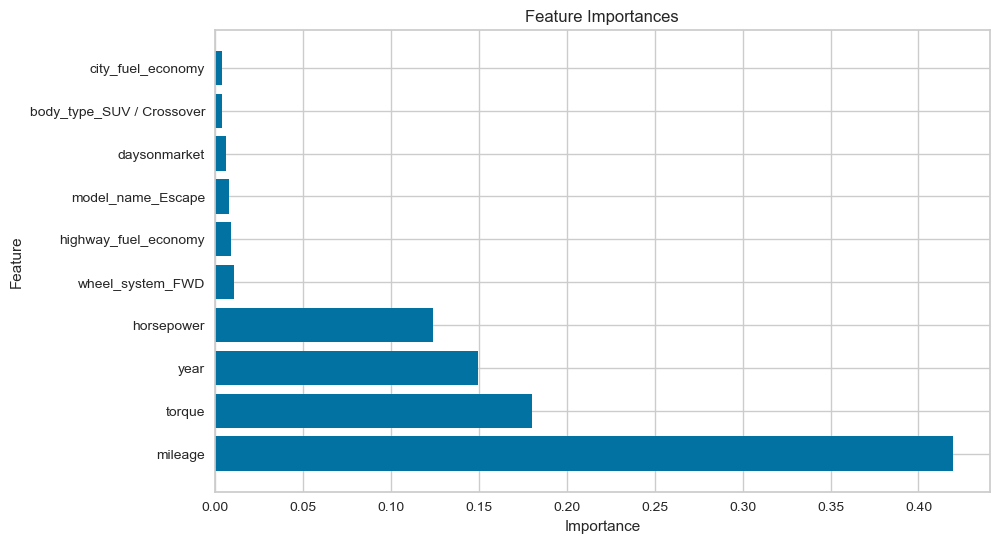

In [8]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)

# Access feature importances
dt_feature_importances = dt_model.feature_importances_

# Create a DataFrame pairing features with their importances
dt_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': dt_feature_importances})

# Sort the DataFrame by importance in descending order
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
#print("Feature Importances:")
#print(dt_feature_importance_df)

dt_top_10_features_df = dt_feature_importance_df.head(10)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(dt_top_10_features_df['Feature'], dt_top_10_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()


#### Taking into account the top 10 features that have high feature importance as a trade-off between predictive performance and model simplicity and computational power. 

In [9]:
dt_feature_importance_df.head(10)

Feature  Importance
5                       mileage    0.419539
8                        torque    0.180365
7                          year    0.149787
4                    horsepower    0.123989
7814           wheel_system_FWD    0.010829
3          highway_fuel_economy    0.009201
4353          model_name_Escape    0.008325
1                  daysonmarket    0.006502
12    body_type_SUV / Crossover    0.004333
0             city_fuel_economy    0.004292

In [10]:
dt_top_10_features_list = dt_feature_importance_df.head(10)['Feature'].tolist()

In [11]:
dt_top_10_features_list.remove('model_name_Escape')

In [12]:
dt_features = dt_top_10_features_list
X = cars_df[dt_features]
X.head()

mileage  torque  year  horsepower  wheel_system_FWD  highway_fuel_economy  \
0   67925.0     275  2014       321.0               0.0                  26.0   
1   32752.0     332  2017       335.0               0.0                  30.0   
2  125477.0     170  2014       178.0               1.0                  35.0   
3   63871.0     252  2006       255.0               0.0                  25.0   
4   42977.0     184  2016       160.0               1.0                  37.0   

   daysonmarket  body_type_SUV / Crossover  city_fuel_economy  
0             7                        0.0               18.0  
1            49                        0.0               20.0  
2            17                        0.0               25.0  
3           106                        0.0               16.0  
4            12                        0.0               27.0

### Decision Trees (without pruning)

In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Decision Tree Regressor model
dt_model = DecisionTreeRegressor(criterion='squared_error',random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

# Calculate and print the performance on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("Decision Tree Training Set Mean Squared Error:", mse_train)
print("Decision Tree Training Set R-squared:", r2_train)

# Calculate and print the performance on the testing set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Decision Tree Testing Set Mean Squared Error:", mse_test)
print("Decision Tree Testing Set R-squared:", r2_test)

Decision Tree Training Set Mean Squared Error: 7.579902165598109e-12
Decision Tree Training Set R-squared: 0.9999999999771172
Decision Tree Testing Set Mean Squared Error: 0.039813674068667405
Decision Tree Testing Set R-squared: 0.8814942019323408


### Decision Trees (with pruning)

Using Randomized Search Cross-Validation technique for hyperparameter tuning to obtain the optimal parameters. The main idea behind RandomizedSearchCV is to efficiently explore a wide range of hyperparameter combinations by sampling only a subset of them, which can be especially useful when the hyperparameter search space is large.

In [14]:

param_dist = {
    'max_depth': np.arange(5, 16),
    'min_samples_leaf': np.arange(2, 11)
}

random_search = RandomizedSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,  # Adjust the number of iterations
    cv=3,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(random_search.best_params_)

{'min_samples_leaf': 9, 'max_depth': 15}


In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Re-training the model with optimal parameters
dt_model = DecisionTreeRegressor(criterion='squared_error', max_depth=15, min_samples_leaf= 9, random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = dt_model.predict(X_train)
y_pred_test = dt_model.predict(X_test)

# Calculate and print the performance on the training set
mse_train = mean_squared_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)
print("Decision Tree Training Set Mean Squared Error:", mse_train)
print("Decision Tree Training Set R-squared:", r2_train)

# Calculate and print the performance on the testing set
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)
print("Decision Tree Testing Set Mean Squared Error:", mse_test)
print("Decision Tree Testing Set R-squared:", r2_test)

Decision Tree Training Set Mean Squared Error: 0.018606738746950072
Decision Tree Training Set R-squared: 0.9438284734516719
Decision Tree Testing Set Mean Squared Error: 0.029729653257820836
Decision Tree Testing Set R-squared: 0.9115093904793509


#### Visualizing the predictions

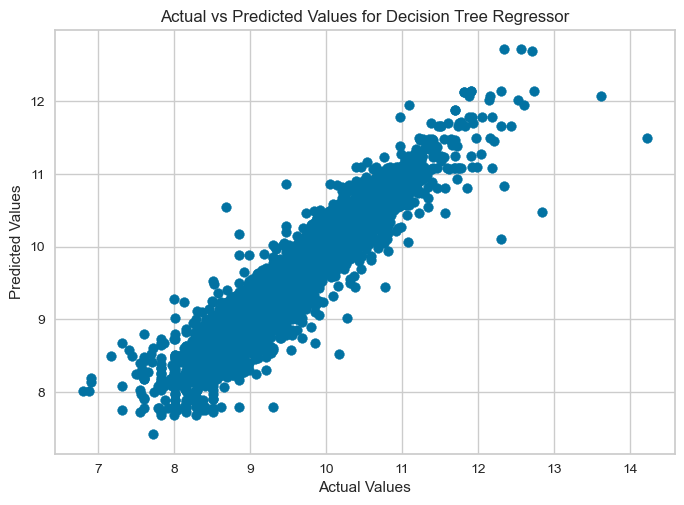

In [16]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Decision Tree Regressor')
plt.show()

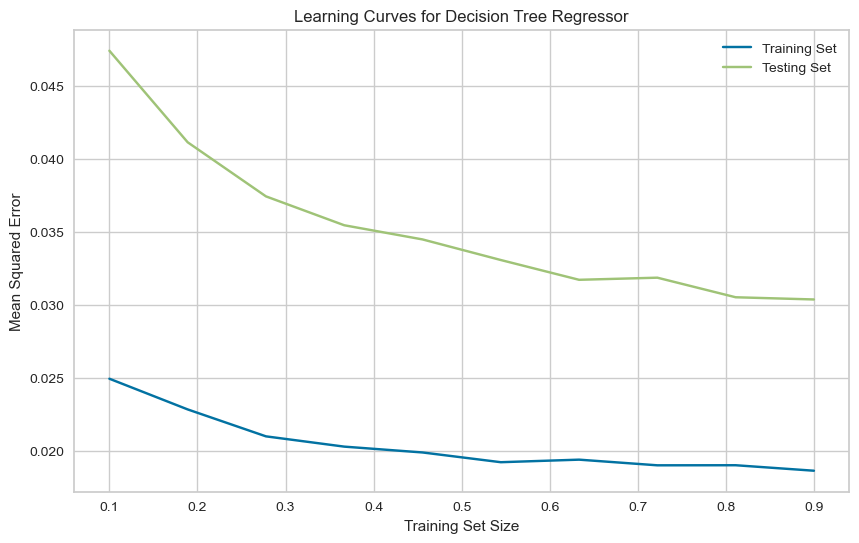

In [17]:
# Vary the size of the training set
train_sizes = np.linspace(0.1, 0.9, 10)

# Lists to store performance metrics
train_mse = []
test_mse = []

# Train the model with different training set sizes
for size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42, shuffle=True)
    
    dt_model.fit(X_train_subset, y_train_subset)
    
    # Predictions on both training and testing sets
    y_pred_train_subset = dt_model.predict(X_train_subset)
    y_pred_test_subset = dt_model.predict(X_test)
    
    # Calculate MSE for both training and testing sets
    train_mse.append(mean_squared_error(y_train_subset, y_pred_train_subset))
    test_mse.append(mean_squared_error(y_test, y_pred_test_subset))

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mse, label='Training Set')
plt.plot(train_sizes, test_mse, label='Testing Set')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves for Decision Tree Regressor')
plt.legend()
plt.show()


The learning curve indicates that the model is learning well from the training data but there is room for improvement. However, this is a conscious trade-off between performance and computational efficiency. 

# Random Forest Regressor

### Calculating the feature importances for training a Decision Tree Regressor with our data:

In [ ]:
X = cars_df.drop('price',axis=1)
X.head()

In [ ]:
cars_df['price'] = np.log(cars_df['price'])
y = cars_df['price']

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model on the training set
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Access feature importances
rf_feature_importances = rf_model.feature_importances_

# Create a DataFrame pairing features with their importances
rf_feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_feature_importances})

# Sort the DataFrame by importance in descending order
rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the DataFrame
# print("Feature Importances:")
# rf_feature_importance_df

rf_top_10_features_df = rf_feature_importance_df.head(10)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(rf_top_10_features_df['Feature'], rf_top_10_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

### Taking into account the top 10 features that have high feature importance as a trade-off between predictive performance and model simplicity and computational power.

In [ ]:
rf_top_10_features_list = rf_feature_importance_df.head(10)['Feature'].tolist()
rf_top_10_features_list.remove('model_name_Escape')
rf_features = rf_top_10_features_list
X = cars_df[rf_features]
X.head()

In [ ]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=150, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate the R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("MSE:", mse)
print("R-squared Score (Random Forest):", r2)


### Hyperparameter tuning the Random Forest Regressor

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters
param_dist = {
    'n_estimators': np.arange(100,150, 50),
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': np.arange(2, 11, 1),
    'min_samples_leaf': np.arange(1, 5, 1),
}

# Use Randomized Search to find the best combination of hyperparameters
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=50, cv=5, scoring='neg_mean_squared_error', n_jobs=2, random_state=42)
random_search.fit(X_train, y_train)

# Get the best parameters from the randomized search
best_params = random_search.best_params_

# Create and train a Random Forest Regressor model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_rf_model.predict(X_test)

# Calculate the R-squared score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Best Hyperparameters:", best_params)
print("MSE:", mse)
print("R-squared Score (Random Forest):", r2)


In [ ]:
plt.scatter(y_test, y_pred_test)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values for Random Forest Regressor')
plt.show()

In [ ]:
# Vary the size of the training set
train_sizes = np.linspace(0.1, 0.9, 10)

# Lists to store performance metrics
train_mse = []
test_mse = []

# Train the model with different training set sizes
for size in train_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=size, random_state=42, shuffle=True)
    
    best_rf_model.fit(X_train_subset, y_train_subset)
    
    # Predictions on both training and testing sets
    y_pred_train_subset = best_rf_model.predict(X_train_subset)
    y_pred_test_subset = best_rf_model.predict(X_test)
    
    # Calculate MSE for both training and testing sets
    train_mse.append(mean_squared_error(y_train_subset, y_pred_train_subset))
    test_mse.append(mean_squared_error(y_test, y_pred_test_subset))

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mse, label='Training Set')
plt.plot(train_sizes, test_mse, label='Testing Set')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves for Random Forest Regressor')
plt.legend()
plt.show()


### Visualizing a part of the Random Forest Regressor

In [ ]:

# Choose a tree from the trained Random Forest model (e.g., the first tree)
tree_to_visualize = best_rf_model.estimators_[0]

# Export the tree to a DOT file
dot_data = export_graphviz(tree_to_visualize, out_file=None, 
                           feature_names=X.columns,  
                           filled=True, rounded=True,  
                           special_characters=True)  

# Visualize the tree using graphviz
graph = graphviz.Source(dot_data)  
graph.render("random_forest_tree") # Gets saved as a PDF file

#### Visualizing a part of the tree

In [ ]:
tree_to_visualize = best_rf_model.estimators_[0]

max_depth_to_visualize = 3

# Export the tree to a DOT file
dot_data = export_graphviz(tree_to_visualize, out_file=None, 
                           feature_names=X.columns,  
                           filled=True, rounded=True,  
                           special_characters=True, 
                          max_depth=max_depth_to_visualize)  

# Visualize the tree using graphviz
graph = graphviz.Source(dot_data)  
graph.render("random_forest_tree_part") # Gets saved as a PDF file

# Convolutional Neural Network

In [2]:
#path to the dataset that contains images of body types of car
body_path = "/Users/sachin/My Files/Data Science/Playground/latest/group-coursework-sa3n/data/CNN/body"
#path to the dataset that contains images of damaged cars
damage_path = "/Users/sachin/My Files/Data Science/Playground/latest/group-coursework-sa3n/data/CNN/damage"

# Load datasets
bodyOriginalData = tf.keras.utils.image_dataset_from_directory(body_path,shuffle=True)
damageOriginalData = tf.keras.utils.image_dataset_from_directory(damage_path,shuffle=True)


Found 2457 files belonging to 7 classes.
Found 1371 files belonging to 3 classes.


In [3]:
#using an iterator to iterate through the data
damageDataIterator=damageOriginalData.as_numpy_iterator()
bodyDataIterator=bodyOriginalData.as_numpy_iterator()

#Getting a batch of data from the iterator
damageBatch = damageDataIterator.next()
bodyBatch = bodyDataIterator.next()

#batch has two values: image, label
#images will be in index 0
#labels will be in index 1
print("length: ",len(damageBatch))

#Images are being represented as numpy arrays   

#32 is the batch size, 256 by 256 is default image size, 3 is for RGB
print("Shape of index 0 (images) ",damageBatch[0].shape) 

#32 labels are present
print("Shape of index 1 (labels) ",damageBatch[1].shape)

# 0 - Minor
# 1 - Moderate
# 2 - Severe
print("labels for damage batch -> ",damageBatch[1])

print("min and max vlues for images are ->",damageBatch[0].min() ,", ",damageBatch[0].max())

# 0 - Convertible
# 1 - Coupe
# 2 - Hatchback
# 3 - Pick-Up
# 4 - Sedan
# 5 - SUV
# 6 - VAN
print("labels for body batch -> ",bodyBatch[1])

length:  2
Shape of index 0 (images)  (32, 256, 256, 3)
Shape of index 1 (labels)  (32,)
labels for damage batch ->  [0 1 0 0 1 1 2 1 0 2 0 2 0 2 2 2 0 2 2 1 0 1 2 0 2 1 0 2 1 0 0 0]
min and max vlues for images are -> 0.0 ,  255.0
labels for body batch ->  [4 5 0 4 0 1 4 2 5 5 2 4 6 6 0 6 0 1 5 2 6 0 0 3 1 2 5 3 5 2 4 0]


2023-11-26 23:18:20.086893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1371]
	 [[{{node Placeholder/_0}}]]
2023-11-26 23:18:20.087116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1371]
	 [[{{node Placeholder/_0}}]]
2023-11-26 23:18:20.092438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]

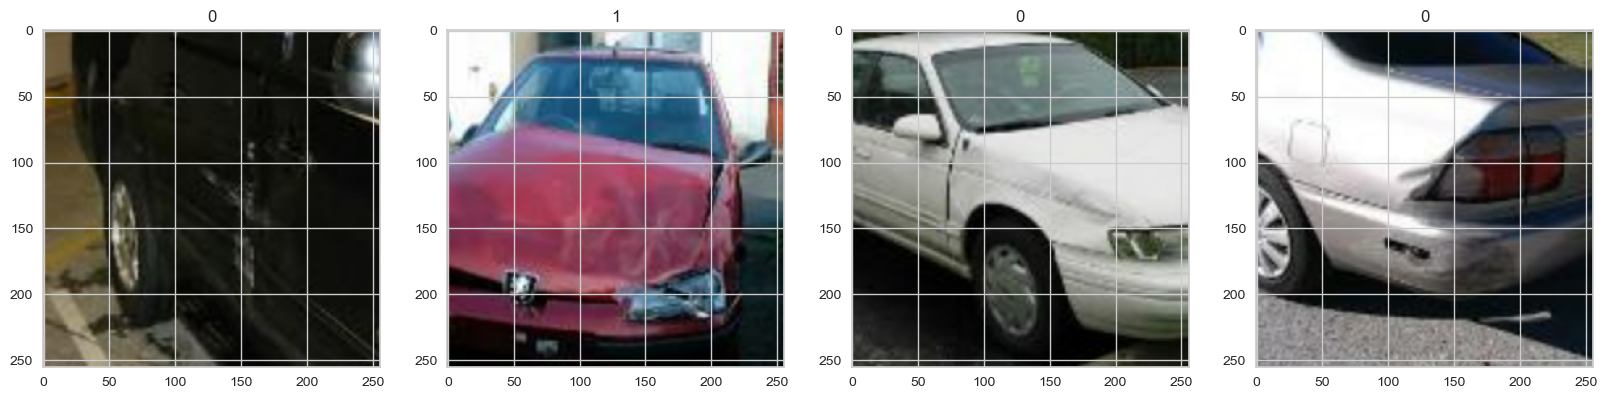

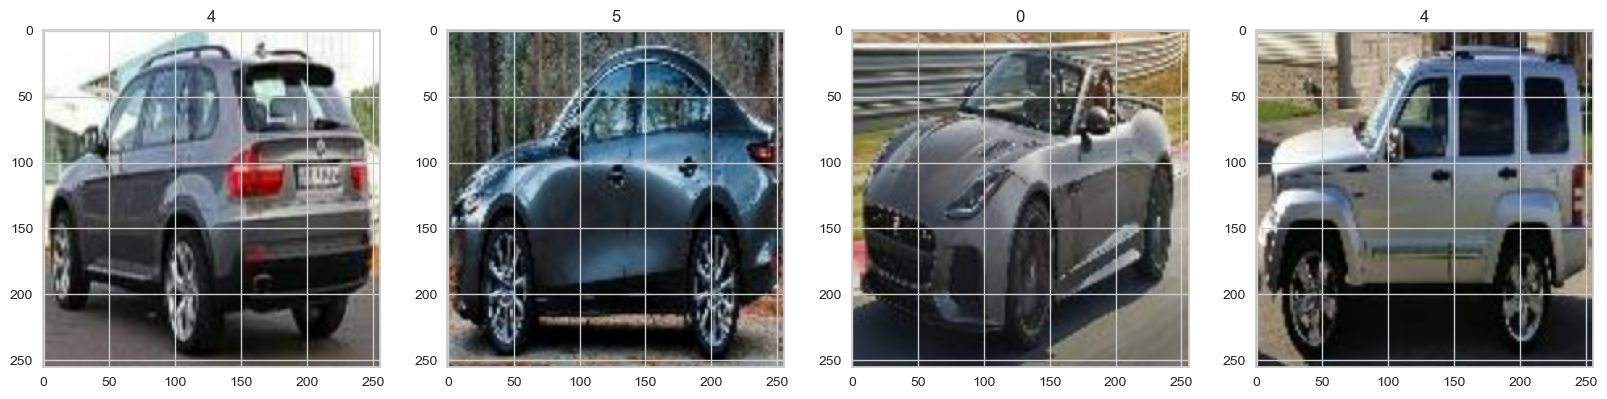

In [4]:
# # Visualising the images and labels to verify everything is working 
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(damageBatch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(damageBatch[1][idx])


fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(bodyBatch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(bodyBatch[1][idx])

# Pre-processing Data

## Scale Data

In [5]:
# Scaling can be done in data augumentation section , so skipping the below code
damageData = damageOriginalData.map(lambda x, y:(x/255, y))
damageScaledIterator=damageData.as_numpy_iterator()
damageScaledBatch=damageScaledIterator.next()

bodyData = bodyOriginalData.map(lambda x, y:(x/255, y))
bodyScaledIterator=bodyData.as_numpy_iterator()
bodyScaledBatch=bodyScaledIterator.next()

2023-11-26 23:18:21.146903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:18:21.147104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:18:21.208950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	

1.0
1.0


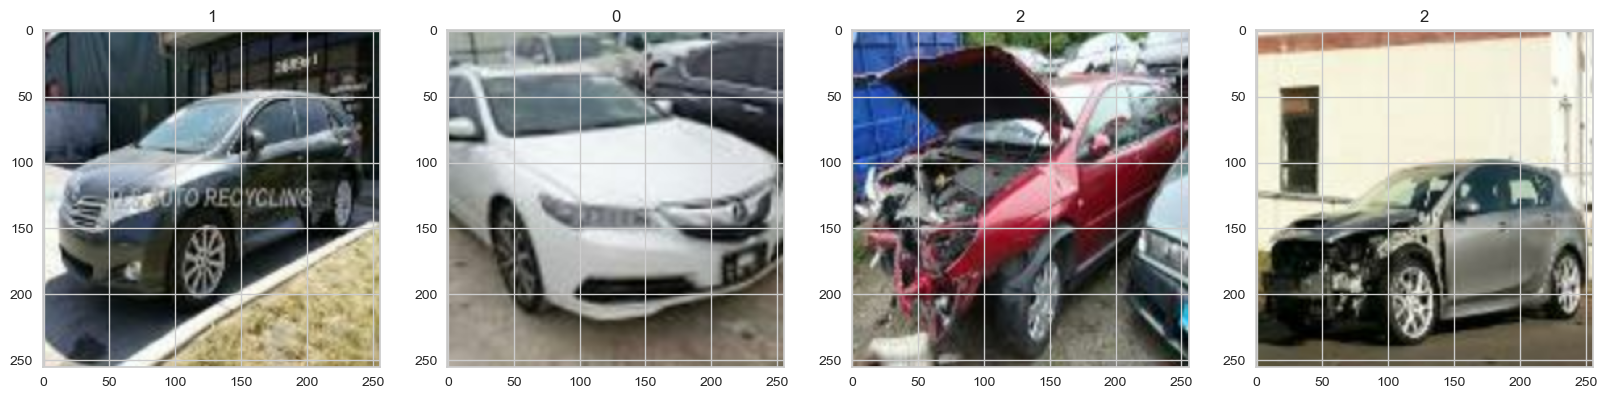

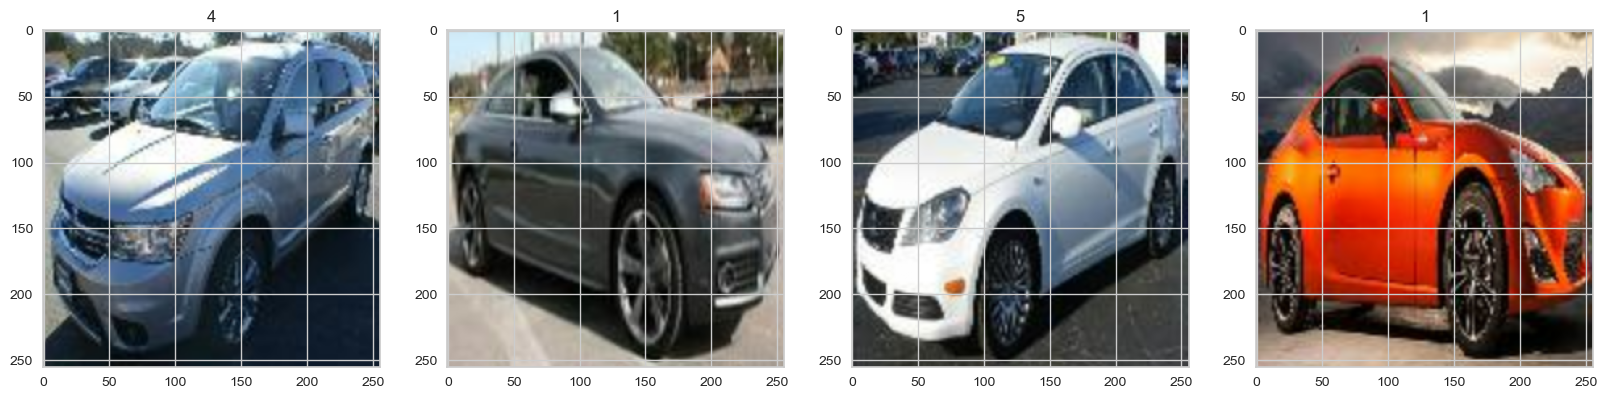

In [6]:
fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(damageScaledBatch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(damageScaledBatch[1][idx])

fig, ax=plt.subplots(ncols=4,figsize=(20,20))
for idx, img in enumerate(bodyScaledBatch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(bodyScaledBatch[1][idx])

print(damageScaledBatch[0].max())
print(bodyScaledBatch[0].max())

In [7]:
print(len(damageData)," batches of damage data is present")
print(len(bodyData), "batches of body data is present")

43  batches of damage data is present
77 batches of body data is present


## Splitting the data into three: train, validation and test

Training data:  used to train our deep learning model\
Validation data: used to evaluate our model while we are training\
Testing data: used to measure the performance of our model by testing

In [8]:
# splitting the data by selecting number of batches for damage data
damageTrainSize= int(len(damageData)*.8)
damageValSize= int(len(damageData)*.1)
damageTestSize= int(len(damageData)*.1)

print(damageTrainSize)
print(damageValSize)
print(damageTestSize)

# adds up to 43 batches which is what we have
print(damageTrainSize+damageValSize+damageTestSize)

# splitting the data by selecting number of batches for body data

bodyTrainSize= int(len(bodyData)*.8)
bodyValSize= int(len(bodyData)*.1)
bodyTestSize= int(len(bodyData)*.1)

print(bodyTrainSize)
print(bodyValSize)
print(bodyTestSize)

# adds up to 154 batches which is what we have
print(bodyTrainSize+bodyValSize+bodyTestSize)

34
4
4
42
61
7
7
75


In [9]:
# skip means we have already selected those number of batches earlier, so lets skip them, and .take after it means lets take the next batch according to the given size
# take means to take the numer of batches that is specified

#assiging the splitted data to different variables for damage dataset
damageTrain=damageData.take(damageTrainSize)
damageValidation=damageData.skip(damageTrainSize).take(damageValSize)
damageTest=damageData.skip(damageTrainSize).skip(damageValSize).take(damageTestSize)

print("Number of batches for training [damage dataset] -> ", len(damageTrain))
print("Number of batches for validation [damage dataset] -> ", len(damageValidation))
print("Number of batches for testing [damage dataset] -> ", len(damageTest),"\n")

#assiging the splitted data to different variables for body dataset
bodyTrain=bodyData.take(bodyTrainSize)
bodyValidation=bodyData.skip(bodyTrainSize).take(bodyValSize)
bodyTest=bodyData.skip(bodyTrainSize).skip(bodyValSize).take(bodyTestSize)

print("Number of batches for training [body dataset] -> ", len(bodyTrain))
print("Number of batches for validation [body dataset] -> ", len(bodyValidation))
print("Number of batches for testing [body dataset] -> ", len(bodyTest))

Number of batches for training [damage dataset] ->  34
Number of batches for validation [damage dataset] ->  4
Number of batches for testing [damage dataset] ->  4 

Number of batches for training [body dataset] ->  61
Number of batches for validation [body dataset] ->  7
Number of batches for testing [body dataset] ->  7


# Deep Learning Model Implementation

Creating the deep learning model

a filter is used to scan over an image and extract a feature or information from the image to make an output classification

For Conv2D()
the first argument '16' means there will be 16 filters or convolutions
the second argument '(3,3)' means the filter is going to be 3 pixels by 3 pixels, so it would scan over the image with this size
the third argument '1' means that it will have a stride of 1, so it will move by 1 pixel to scan over the image
the fourth argument 'activation='relu'' means that any output of the layer below 0 (negative values) would be converted to 0 and positive values would be preserved
the fifth argument means that the first layer is going to be an input layer -> with 256 by 256 size color images

For MaxPooling2D()
the default size of MaxPooling2D is 2 pixels by 2 pixels
this layer scans over the output values of the image regions of convolution layer and takes the maximum value from it according to size specified (default 2 by 2 pixels)

For Flatten()
we are flattening the channel values of the filters to a single value

For Dense()
the first argument means we have 256 neurons

In [10]:
# Defining the CNN Deep Learning model, this will be used to train both damage and body models

def defineModel(numOfClasses):
    model=Sequential()
    model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape = (256,256,3)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))

    model.add(Conv2D(16, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D())
    model.add(Dropout(0.05))

    model.add(Conv2D(32, (3,3), 1, activation='relu'))
    model.add(MaxPooling2D()) 
    model.add(Dropout(0.2))

    model.add (Flatten()) 
    model.add (Dense (256, activation='relu'))
    

    model.add(Dense(numOfClasses, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    

### Defining or Creating the model for damage dataset

In [11]:

damageModel = defineModel(3)
bodyModel = defineModel(7)
# damageModel = dataAug()

In [12]:
damageModel.summary()

"""
The calculation for how many unique positions you can apply the kernel in each dimension (width or height) is given by "(Image Size - Kernel Size + 1)".
In this case, the image size is 256 (width and height) and the kernel size is 3.
So, the number of positions is calculated as 
256 3 + 1 = 254
This means the kernel can be applied 254 times along both the width and the height of the image."""


"""
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
=================================================================
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448            -> this means the first conv2d layer has been applied and it converted the size of image such that it can scan over it | 16 is the number of filters has been applied on the image
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 14400)             0         -> 30 * 30 * 16 is 14400, we are just flattening our multidimensional layer into a single dimension
                                                                 
 dense_2 (Dense)             (None, 256)               3686656   -> 
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
=================================================================
Total params: 3,697,139
Trainable params: 3,697,139
Non-trainable params: 0
_________________________________________________________________

"""


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 16)        0

'\n_________________________________________________________________\n Layer (type)                Output Shape              Param #   \n=================================================================\n conv2d_4 (Conv2D)           (None, 254, 254, 16)      448            -> this means the first conv2d layer has been applied and it converted the size of image such that it can scan over it | 16 is the number of filters has been applied on the image\n                                                                 \n max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         \n 2D)                                                             \n                                                                 \n conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      \n                                                                 \n max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         \n 2D)                                                             \n          

In [13]:
bodyModel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 127, 127, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 16)      4624      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 62, 62, 16)       

## Training the Model

In [14]:
# model.fit is the training component

# damageTrain has the training data
# epochs means the number of training steps we are going to take OR 1 epoch is 1 run over entire training set of data
# validation_data is used to do an evaluation on the validation data once the model is trained, to see in real time how well the model is performing
# callbacks is used to log out all information on our model to tensorboard
# history helps us to take out all training information from training data and validation and help us to plot the values to visualise it

# Training Damage Model


historyDamageModel = damageModel.fit(
    damageTrain,
    epochs = 30, 
    validation_data=damageValidation)


Epoch 1/30


2023-11-26 23:18:22.821364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:18:22.821597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]


34/34 [==============================] - ETA: 0s - loss: 1.5562 - accuracy: 0.3392

2023-11-26 23:18:33.586613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:18:33.586836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1371]
	 [[{{node Placeholder/_0}}]]


34/34 [==============================] - 11s 306ms/step - loss: 1.5562 - accuracy: 0.3392 - val_loss: 1.1001 - val_accuracy: 0.3594
Epoch 2/30
34/34 [==============================] - 10s 301ms/step - loss: 1.0997 - accuracy: 0.3548 - val_loss: 1.0973 - val_accuracy: 0.3359
Epoch 3/30
34/34 [==============================] - 10s 299ms/step - loss: 1.0936 - accuracy: 0.3906 - val_loss: 1.0894 - val_accuracy: 0.3828
Epoch 4/30
34/34 [==============================] - 9s 275ms/step - loss: 1.0668 - accuracy: 0.4311 - val_loss: 1.0842 - val_accuracy: 0.3594
Epoch 5/30
34/34 [==============================] - 9s 270ms/step - loss: 0.9921 - accuracy: 0.5239 - val_loss: 0.9592 - val_accuracy: 0.5078
Epoch 6/30
34/34 [==============================] - 9s 267ms/step - loss: 0.8877 - accuracy: 0.6149 - val_loss: 0.9791 - val_accuracy: 0.5547
Epoch 7/30
34/34 [==============================] - 9s 272ms/step - loss: 0.7745 - accuracy: 0.6737 - val_loss: 0.9227 - val_accuracy: 0.5859
Epoch 8/30
34/

In [15]:
# The history can be seen using the below statement
# print(historyDamageModel.history)

# Assuming historyBodyModel is the output of the fit method as shown in your code

# Accessing the metrics
loss = historyDamageModel.history['loss']
accuracy = historyDamageModel.history['accuracy']
val_loss = historyDamageModel.history['val_loss']
val_accuracy = historyDamageModel.history['val_accuracy']

# Calculating the averages
average_loss = sum(loss) / len(loss)
average_accuracy = sum(accuracy) / len(accuracy)
average_val_loss = sum(val_loss) / len(val_loss)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

# Printing the results
print("Average Loss:", average_loss)
print("Average Accuracy:", average_accuracy)
print("Average Validation Loss:", average_val_loss)
print("Average Validation Accuracy:", average_val_accuracy)



Average Loss: 0.3512938385208448
Average Accuracy: 0.8424325952927272
Average Validation Loss: 0.6899659961462021
Average Validation Accuracy: 0.75703125


In [16]:
# Training Body Model
historyBodyModel = bodyModel.fit(bodyTrain, epochs = 30, validation_data=bodyValidation)

Epoch 1/30


2023-11-26 23:23:11.580922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:23:11.581144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	 [[{{node Placeholder/_4}}]]


61/61 [==============================] - ETA: 0s - loss: 2.0267 - accuracy: 0.2054

2023-11-26 23:23:27.836366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:23:27.836594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2457]
	 [[{{node Placeholder/_0}}]]


61/61 [==============================] - 17s 273ms/step - loss: 2.0267 - accuracy: 0.2054 - val_loss: 1.8122 - val_accuracy: 0.2723
Epoch 2/30
61/61 [==============================] - 16s 265ms/step - loss: 1.5480 - accuracy: 0.4180 - val_loss: 1.3116 - val_accuracy: 0.5714
Epoch 3/30
61/61 [==============================] - 16s 265ms/step - loss: 1.0109 - accuracy: 0.6327 - val_loss: 1.1929 - val_accuracy: 0.6161
Epoch 4/30
61/61 [==============================] - 16s 265ms/step - loss: 0.6615 - accuracy: 0.7674 - val_loss: 0.9135 - val_accuracy: 0.7232
Epoch 5/30
61/61 [==============================] - 16s 266ms/step - loss: 0.3737 - accuracy: 0.8714 - val_loss: 0.7587 - val_accuracy: 0.7500
Epoch 6/30
61/61 [==============================] - 21s 347ms/step - loss: 0.2472 - accuracy: 0.9216 - val_loss: 1.0123 - val_accuracy: 0.7143
Epoch 7/30
61/61 [==============================] - 20s 330ms/step - loss: 0.1479 - accuracy: 0.9575 - val_loss: 0.9328 - val_accuracy: 0.7768
Epoch 8/30

In [17]:
# Accessing the metrics
loss = historyBodyModel.history['loss']
accuracy = historyBodyModel.history['accuracy']
val_loss = historyBodyModel.history['val_loss']
val_accuracy = historyBodyModel.history['val_accuracy']

# Calculating the averages
average_loss = sum(loss) / len(loss)
average_accuracy = sum(accuracy) / len(accuracy)
average_val_loss = sum(val_loss) / len(val_loss)
average_val_accuracy = sum(val_accuracy) / len(val_accuracy)

# Printing the results
print("Average Loss:", average_loss)
print("Average Accuracy:", average_accuracy)
print("Average Validation Loss:", average_val_loss)
print("Average Validation Accuracy:", average_val_accuracy)


Average Loss: 0.23171581352750462
Average Accuracy: 0.9156420757373174
Average Validation Loss: 1.2401186267534892
Average Validation Accuracy: 0.7709821432828903


## Plotting the Performance for Damage Model

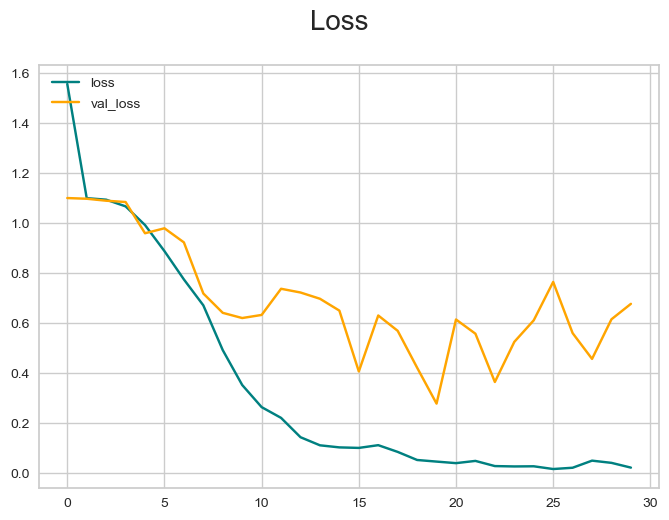

In [18]:

# Plotting LOSS 

# !!! need to add regularisation to decrease the val_loss, plot suggests model is overfitting !!!

fig = plt.figure()
plt.plot(historyDamageModel.history['loss'],color='teal', label='loss')
plt.plot(historyDamageModel.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt. show()

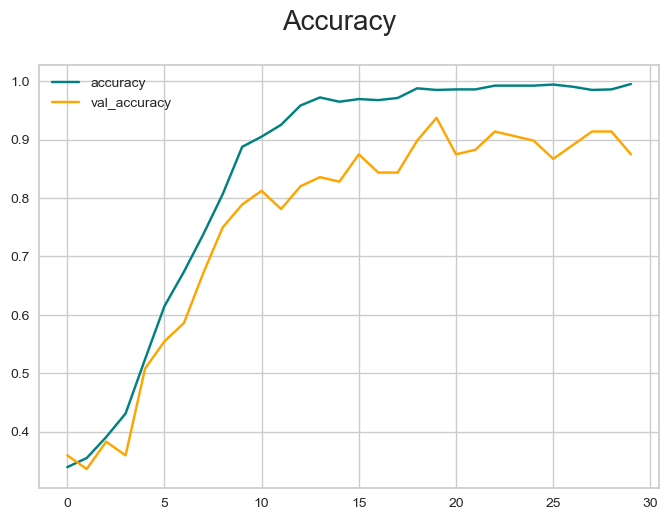

In [19]:
# Plotting Accuracy

fig = plt. figure()
plt.plot(historyDamageModel.history['accuracy'],color='teal', label='accuracy')
plt.plot(historyDamageModel.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt. show()

## Plotting the Performance for Body Model

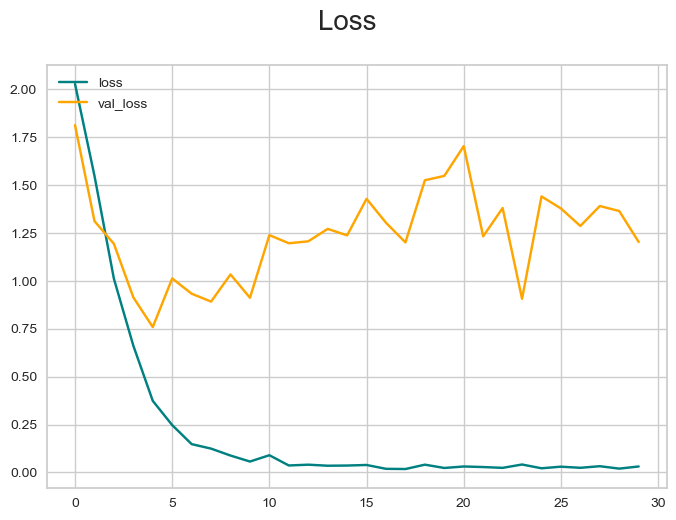

In [20]:

# Plotting LOSS 

# !!! need to add regularisation to decrease the val_loss, plot suggests model is overfitting !!!

fig = plt.figure()
plt.plot(historyBodyModel.history['loss'],color='teal', label='loss')
plt.plot(historyBodyModel.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt. show()

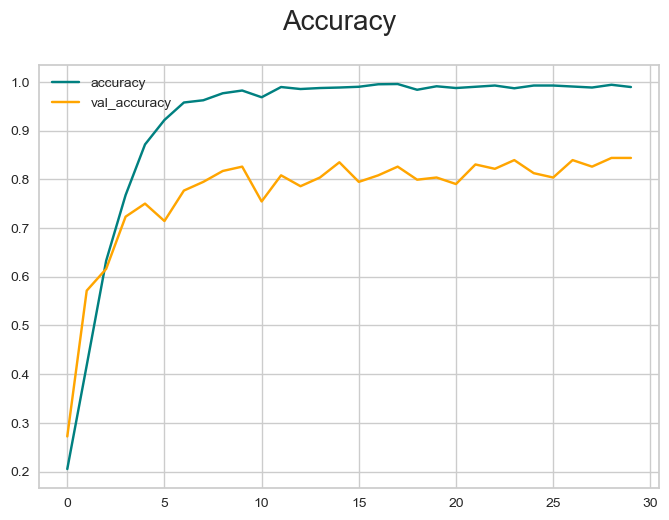

In [21]:
# Plotting Accuracy

fig = plt. figure()
plt.plot(historyBodyModel.history['accuracy'],color='teal', label='accuracy')
plt.plot(historyBodyModel.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt. show()

## Evaluating the performance of the Damage Model

In [22]:
len(damageTest)
len(bodyTest)

7

In [23]:
test_loss, test_accuracy = damageModel.evaluate(damageTest)
print(f"Test Accuracy of Damage Model: {test_accuracy * 100:.2f}%")
print(f"Test Loss of Damage Model: {test_loss * 100:.2f}%")

test_loss, test_accuracy = bodyModel.evaluate(bodyTest)
print(f"Test Accuracy of Body Model: {test_accuracy * 100:.2f}%")
print(f"Test Loss of Body Model: {test_loss * 100:.2f}%")

2023-11-26 23:31:59.360239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:31:59.360509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1371]
	 [[{{node Placeholder/_4}}]]


4/4 [==============================] - 1s 73ms/step - loss: 0.5058 - accuracy: 0.9219
Test Accuracy of Damage Model: 92.19%
Test Loss of Damage Model: 50.58%


2023-11-26 23:31:59.886449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	 [[{{node Placeholder/_4}}]]
2023-11-26 23:31:59.886689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2457]
	 [[{{node Placeholder/_4}}]]


7/7 [==============================] - 1s 78ms/step - loss: 2.7138 - accuracy: 0.6652
Test Accuracy of Body Model: 66.52%
Test Loss of Body Model: 271.38%


## DAMAGE MODEL - Visualising the predictions done on the test data 

1/1 [==============================] - 0s 124ms/step


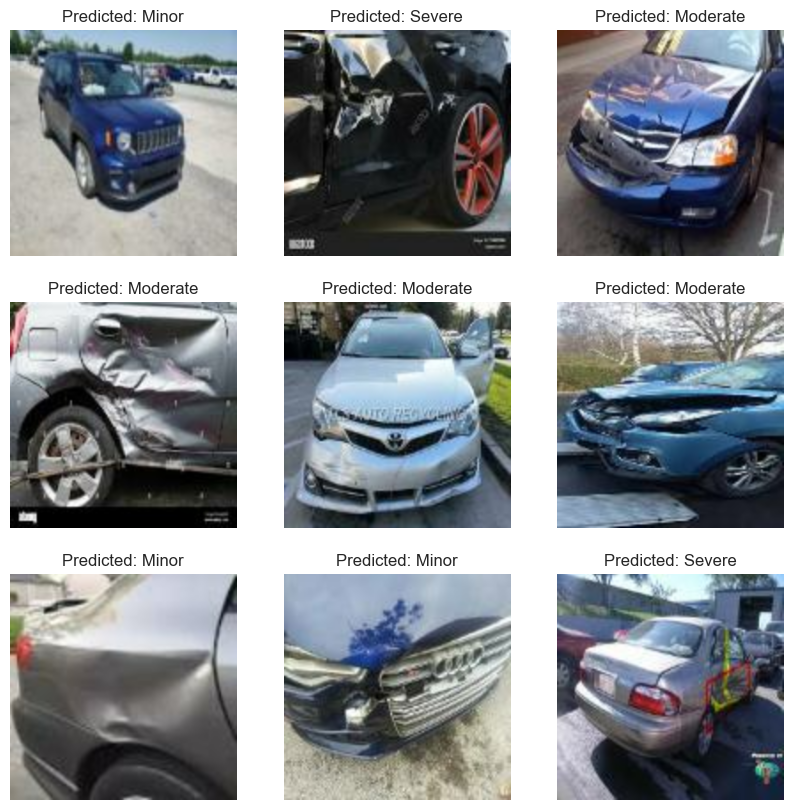

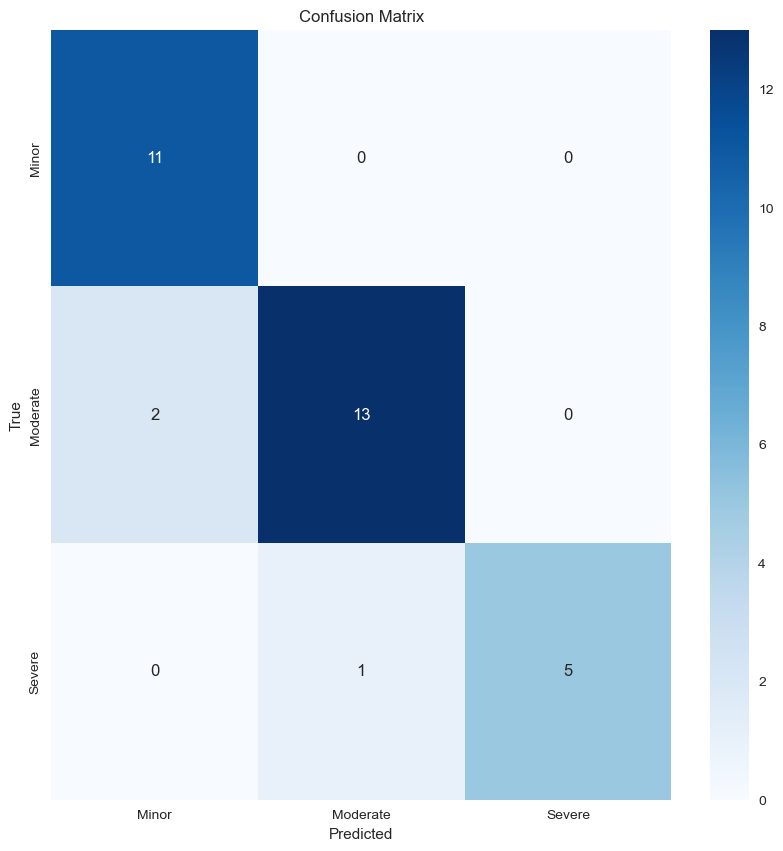

In [24]:

# plotting testing results of damage model
# Get a batch of test data
damageClass=['Minor','Moderate','Severe']


dmg_test_images, dmg_test_labels = next(iter(damageTest))

# Make predictions
predictions = damageModel.predict(dmg_test_images)

# Plot the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dmg_test_images[i])
    plt.title('Predicted: {}'.format(damageClass[np.argmax(predictions[i])]))
    plt.axis('off')
plt.show()


#Confusion Matrix
# Convert predictions to class indices
predicted_classes = np.argmax(predictions, axis=1)


# Build the confusion matrix
dmgCM = confusion_matrix(dmg_test_labels, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(dmgCM, annot=True, fmt='d', cmap='Blues',xticklabels=damageClass, yticklabels=damageClass)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## Body MODEL - Visualising the predictions done on the test data 

1/1 [==============================] - 0s 89ms/step


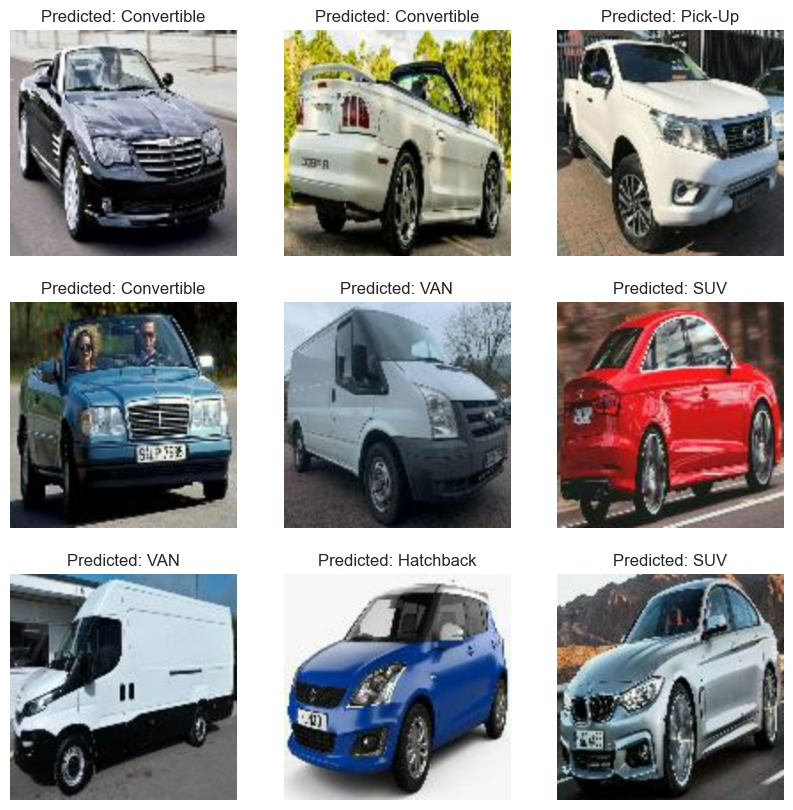

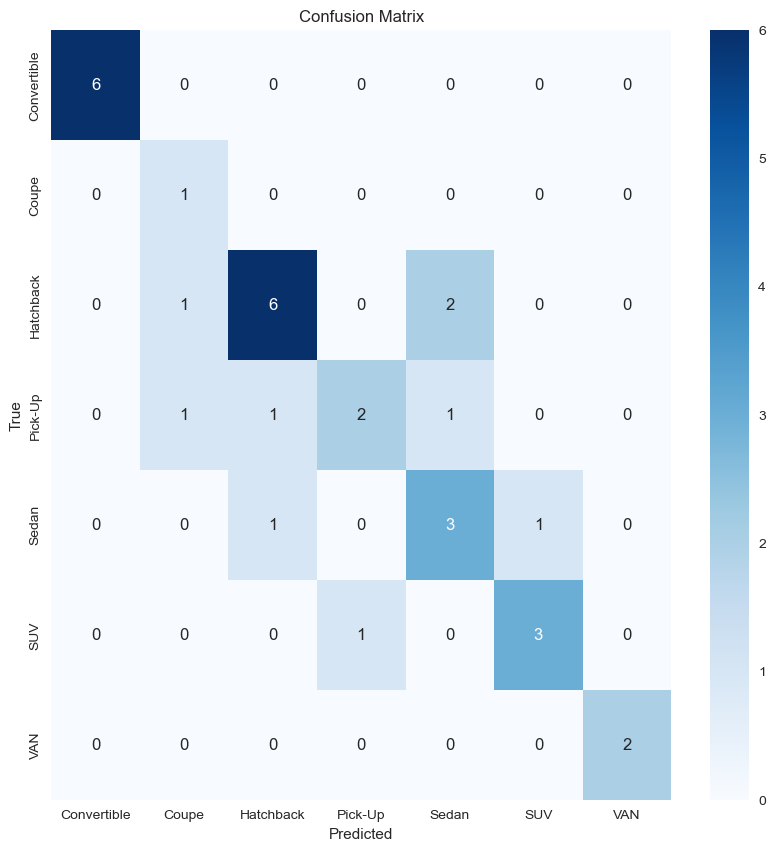

In [28]:

# plotting testing results of damage model

bodyClasses = ["Convertible", "Coupe", "Hatchback","Pick-Up","Sedan","SUV","VAN"]

# Get a batch of test data

body_test_images, body_test_labels = next(iter(bodyTest))

# Make predictions
bodyPredictions = bodyModel.predict(body_test_images)

# Plot the images and their predicted labels
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(body_test_images[i])
    plt.title('Predicted: {}'.format(bodyClasses[np.argmax(bodyPredictions[i])]))
    plt.axis('off')
plt.show()

# Convert predictions to class indices
body_predicted_classes = np.argmax(bodyPredictions, axis=1)


# Build the confusion matrix
bodyCM = confusion_matrix(body_test_labels, body_predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(bodyCM, annot=True, fmt='d', cmap='Blues',xticklabels=bodyClasses, yticklabels=bodyClasses)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()